<h1><center>Spaceship Titanic Prediction - Supervised Learning</center></h1>
<center>October 2024</center>
<center>Celine Ng</center>

# Table of Contents

1. Project Introduction   
    1. Notebook Preparation
    1. Dataset
1. Initial Data Cleaning
    1. Duplicate rows
    1. Datatypes
    1. Missing values
1. EDA
    1. Correlation
    1. Statistical Inference
    1. Distribution
1. Data Preprocessing
1. Feature Selection
    1. All features included
    1. Mutual Information
    1. PCA
1. Models
    1. Baseline model
    1. Basic model
    1. Hyperparameter Tuning
    1. Final Model
1. Deploy the model
1. Improvements

# 1. Project Introduction

## 1.1. Notebook Preparation

In [1]:
%%capture
%pip install -r requirements.txt

In [2]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.eda import *
from utils.model import *
from utils.stats import *
from scipy.stats import mannwhitneyu

from sklearn.compose import make_column_selector as selector
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import (KFold, cross_val_score)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder, 
                                   FunctionTransformer,
                                   StandardScaler)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             precision_score, recall_score, roc_curve, auc, 
                             make_scorer)
import graphviz
import shap
import optuna
import pickle
from fastapi import FastAPI

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 1.2. Dataset

Objective: Brief overview of our dataset, including the features and target 
variable

The dataset was downloaded from Kaggle, [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic/data?select=train.csv)
, on 18 October 2024. <br>
This dataset is part of an open Kaggle competition, 
where the task is to predict whether a passenger was transported to an 
alternate dimension during the Spaceship Titanic's collision with the 
spacetime anomaly. <br>
The data originally comes in 2 separate datasets, *train.csv* and *test.csv*
. Each dataset contains a set of personal records recovered from the ship's
 damaged computer system. There are 13 columns of personal records, and the 
 14th column is the target.

- train.csv - Personal records for about two-thirds (~8700) of the 
passengers, to be used as training data.
- test.csv - Personal records for the remaining one-third (~4300) of the 
passengers, to be used as test data. Does not include the target variable. 
My task is to predict the value of Transported for the passengers in this set.
<ol>
<li>PassengerId - A unique Id for each passenger. Each Id takes the form 
gggg_pp where gggg indicates a group the passenger is travelling with and pp
 is their number within the group. People in a group are often family 
 members, but not always.</li>
<li>HomePlanet - The planet the passenger departed from, typically their planet
 of permanent residence.</li>
<li>CryoSleep - Indicates whether the passenger elected to be put into 
suspended animation for the duration of the voyage. Passengers in cryosleep 
are confined to their cabins.</li>
<li>Cabin - The cabin number where the passenger is staying. Takes the form 
deck/num/side, where side can be either P for Port or S for Starboard.</li>
<li>Destination - The planet the passenger will be debarking to.</li>
<li>Age - The age of the passenger.</li>
<li>VIP - Whether the passenger has paid for special VIP service during the 
voyage.</li>
<li>RoomService - Amount the passenger has billed at this luxury amenity. </li>
<li>FoodCourt - Amount the passenger has billed at this luxury amenity. </li>
<li>ShoppingMall - Amount the passenger has billed at this luxury amenity. </li>
<li>Spa - Amount the passenger has billed at this luxury amenity. </li>
<li>VRDeck - Amount the passenger has billed at this luxury amenity. </li>
<li>Name - The first and last names of the passenger.</li>
<li>Transported - Whether the passenger was transported to another dimension. 
This is the target, the column I am trying to predict.</li>
</ol>

In [3]:
spaceship_train = pd.read_csv('data/train.csv')
display(spaceship_train.head())
spaceship_train_shape = spaceship_train.shape
print(f"Number of rows on train data: {spaceship_train_shape[0]}\nNumber of "
      f"columns on train data: {spaceship_train_shape[1]}")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Number of rows on train data: 8693
Number of columns on train data: 14


# 2. Initial Data cleaning
Objective:
1. Closer look at the values that consist of our data
2. Look out for duplicates, and missing and/or unusual values

## 2.1. Duplicate rows

In [4]:
print(spaceship_train['PassengerId'].duplicated().any())

False


## 2.2. Datatypes

In [5]:
spaceship_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In our feature columns, there is only 'object' and 'float' datatypes, the 
target variable is in 'bool'.

## 2.3. Missing values

In [6]:
print(spaceship_train.isnull().sum().sum())

2324


In [7]:
missing_values(df=spaceship_train)

,Missing Values,Percentage Missing
PassengerId,0,0.00
HomePlanet,201,2.31
CryoSleep,217,2.50
Cabin,199,2.29
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39


There is missing values all over the dataset, except for PassengerId and the
 target variable. The amount of missing value is also quite similar across 
 all features, numbers ranging around 200.

## 2.4. Values

Brief overview of the overall distribution for numerical features, the 
values itself for the rest.

In [8]:
spaceship_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


The range of values is very different when comparing 'Age' to other 
features, but not their interquartile range (IQR). <br>
Also notice that the median value for these other features are 0, regardless
 of their maximum value. This is indicating outliers with extreme values. 

In [9]:
spaceship_train.describe(include=['object', 'bool'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
count,8693,8492,8476,8494,8511,8490,8493,8693
unique,8693,3,2,6560,3,2,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall,True
freq,1,4602,5439,8,5915,8291,2,4378


Looking into the values, these categorical features fit into several types of 
categories. 
<br>
1. PassengerId, Cabin, Name: features containing many unique values. Could 
contain multiple information, which could be extracted.
2. HomePlanet, Destination: Nominal features 
3. CyroSleep, VIP, Transported: True/False values. Boolean variable

The target variable, Transported, is well divided between 2 classes, our 
dataset does NOT have imbalance issues.

**PassengerID, Name, Cabin**<br>

PassengerId contains useful information like whether a passenger belonged to
 a group, and the group size.

In [10]:
spaceship_train['Group'] = spaceship_train['PassengerId'].apply(lambda x: x.split('_')[0])
spaceship_train['GroupSize'] = spaceship_train.groupby('Group')['Group'].transform('count')
spaceship_train['InGroup'] = spaceship_train['GroupSize'] > 1

spaceship_train[['Group', 'GroupSize', 'InGroup']].head()

,Group,GroupSize,InGroup
0,0001,1,False
1,0002,1,False
2,0003,2,True
3,0003,2,True
4,0004,1,False


There is no relevant information in the passenger's names.

In [11]:
spaceship_train = spaceship_train.drop(['Name'], axis=1)

Cabin can be broken down into 3 features, deck, num, side

In [12]:
spaceship_train[['Deck', 'Num', 'Side']] = spaceship_train['Cabin'].str.split('/', expand=True)
spaceship_train[['Cabin', 'Deck', 'Num', 'Side']].head()

,Cabin,Deck,Num,Side
0,B/0/P,B,0,P
1,F/0/S,F,0,S
2,A/0/S,A,0,S
3,A/0/S,A,0,S
4,F/1/S,F,1,S


# 3. EDA

## 3.1. Correlation
Objective:<br>
1. Correlations between features
2. Correlations between features and target

**Correlation between features**

In [13]:
df_1 = spaceship_train.copy()
spaceship_eda = df_1

target_name = 'Transported'
data, target = (spaceship_eda.drop(columns=[target_name]), 
                spaceship_eda[target_name])

PassengerId and Cabin are not needed as their information is extracted to 
new columns.<br>
Separate the rest of the columns for correlation purposes.

In [14]:
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 
                     'Spa', 'VRDeck']
ordinal_yesno_columns = ['CryoSleep', 'VIP', 'InGroup', 'GroupSize',
                        'Num', 'Deck', 'Side']
multicat_columns = ['HomePlanet', 'Destination', 'Group']

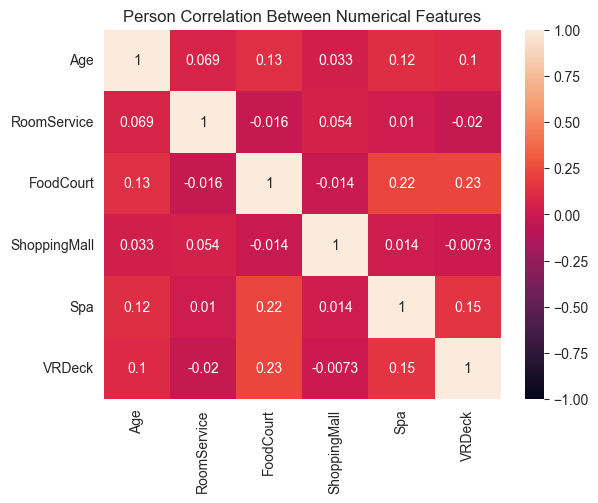

In [15]:
corr = spaceship_eda[numerical_columns].corr()
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.title('Person Correlation Between Numerical Features')
plt.show()

All numerical features are weakly linearly correlated, it is not enough 
to cause any issues in our models. <br>
The most significant finding is between FoodCourt and VRDeck or Spa. There 
is also other correlations between luxury amenities spending, which is 
expected as it is there could be other confounding factors like income.

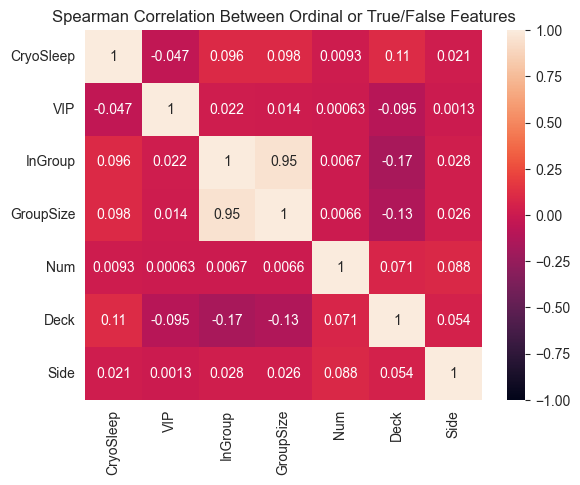

In [16]:
le = LabelEncoder()
for col in ordinal_yesno_columns:
    spaceship_eda[col] = le.fit_transform(spaceship_eda[col].astype(str))

corr = spaceship_eda[ordinal_yesno_columns].corr('spearman')
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.title('Spearman Correlation Between Ordinal or True/False Features')
plt.show()

Looking into the monotonic relationships between ordinal or 
True/False features, we see most are extremely weak.<br>
The exceptions found are between InGroup, GroupSize, and Deck. The 
correlation between InGroup and GroupSize is very strong and also clearly 
due to the fact that all passengers without a group, have groupsize=1.

In [17]:
cramers_v_results = {}
for col1 in multicat_columns:
    for col2 in multicat_columns:
        if col1 != col2:
            cramers_v_results[(col1, col2)] = cramers_v(spaceship_eda[col1],
                                                        spaceship_eda[col2])

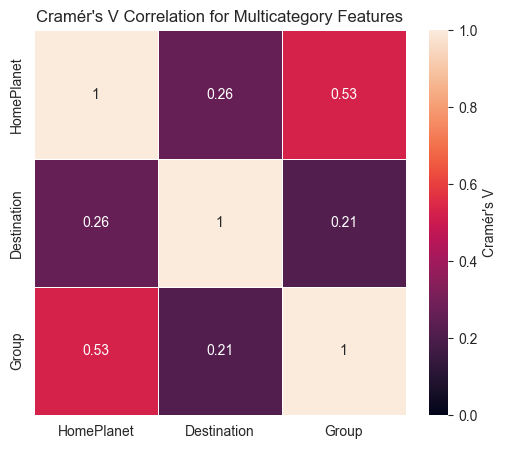

In [18]:
heatmap_matrix = np.ones((len(multicat_columns), len(multicat_columns)))

for (cat1, cat2), value in cramers_v_results.items():
    i, j = multicat_columns.index(cat1), multicat_columns.index(cat2)
    heatmap_matrix[i, j] = value
    heatmap_matrix[j, i] = value

heatmap_df = pd.DataFrame(heatmap_matrix, index=multicat_columns, 
                          columns=multicat_columns)

plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_df, annot=True, vmin=0, vmax=1,
            linewidths=0.5, cbar_kws={"label": "Cramér's V"})
plt.title("Cramér's V Correlation for Multicategory Features")
plt.show()

HomePlanet is moderate to strongly correlated with Group. Other features are
 weak to moderately correlated, the dataset can benefit from some feature 
 selection before applying machine learning models.

**Correlation features vs target**

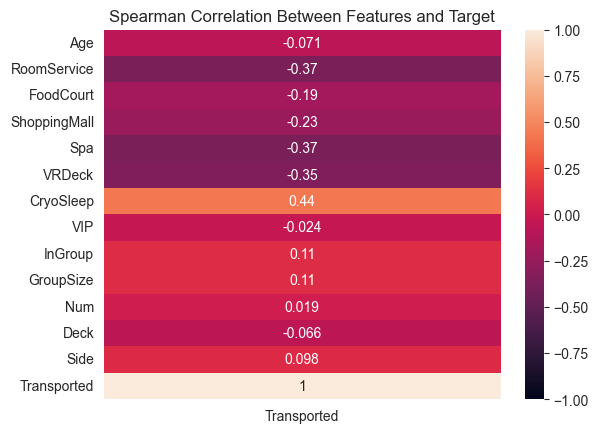

In [19]:
columns = numerical_columns + ordinal_yesno_columns + [target_name]

corr = spaceship_eda[columns].corr('spearman')[[target_name]]
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.title('Spearman Correlation Between Features and Target')
plt.show()

In [20]:
cramers_v_results = {}
for col1 in multicat_columns:
        cramers_v_results[col1] = (
            cramers_v(spaceship_eda[col1],spaceship_eda[target_name])
        )

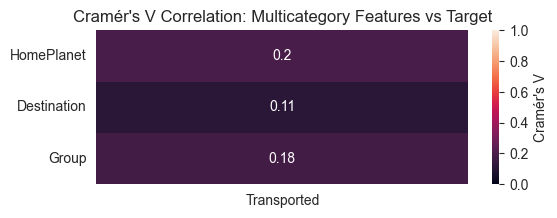

In [21]:
heatmap_df = pd.DataFrame(cramers_v_results, index=[target_name]).T

plt.figure(figsize=(6, 2))
sns.heatmap(heatmap_df, annot=True, vmin=0, vmax=1,
            cbar_kws={"label": "Cramér's V"})
plt.title("Cramér's V Correlation: Multicategory Features vs Target")
plt.show()

Features vs Target:<br>
1. In the Spearman's correlation, 'CryoSleep' has the best correlation found
. 'Age', 'VIP', 'Deck', 'Num', and 'Side' have 
extremely low values. While all luxury amenities are low to moderately 
correlated with the target variable. <br>
2. Values between Spearman's correlation and Cramers V correlation are not 
directly comparable. However, the multicategorical features, like luxury 
amenities, are weak to moderately correlated with the target variable. <br><br>

Important to consider that the features low to moderately correlated with 
target variable, luxury amenities and multicategory, also show some level
 of correlation between themselves. However, interestingly the best 
 correlated feature, 'CryoSleep', did not show correlations with other 
 ordinal/binary features.<br>
 
It would be relevant to check if 'CryoSleep' were correlated with luxury 
amenities and multicategorical features. Also, if correlations were 
statistically significant.

**Correlation - CryoSleep and other features**

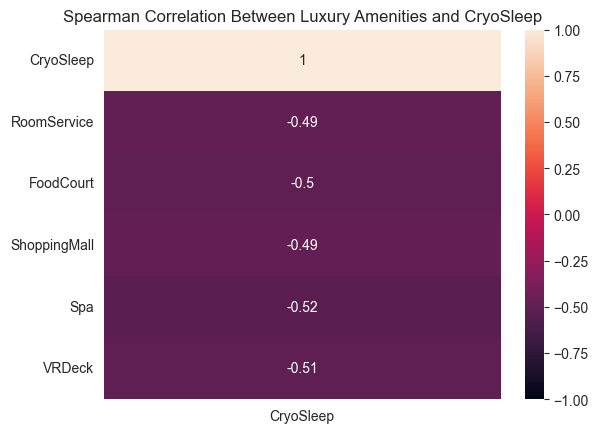

In [22]:
columns = ['CryoSleep', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 
           'VRDeck']

corr = spaceship_eda[columns].corr('spearman')[['CryoSleep']]
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.title('Spearman Correlation Between Luxury Amenities and CryoSleep')
plt.show()

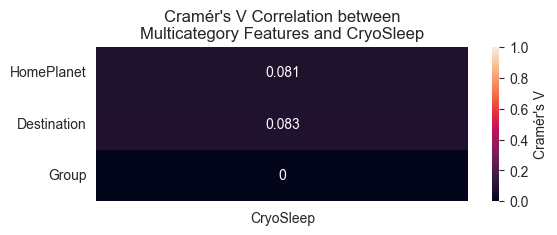

In [23]:
cramers_v_results = {}
for col1 in multicat_columns:
        cramers_v_results[col1] = (
            cramers_v(spaceship_eda[col1],spaceship_eda['CryoSleep'])
        )
        
heatmap_df = pd.DataFrame(cramers_v_results, index=['CryoSleep']).T

plt.figure(figsize=(6, 2))
sns.heatmap(heatmap_df, annot=True, vmin=0, vmax=1,
            cbar_kws={"label": "Cramér's V"})
plt.title("Cramér's V Correlation between\nMulticategory Features and "
          "CryoSleep")
plt.show()

CryoSleep shows negligible correlations with multicatgory features, and 
moderate to strong correlations with all luxury amenity features as 
expected, as passengers in CryoSleep cannot leave their cabin. <br>
The following will show the true correlation between amenities spending and 
whether they were transported.

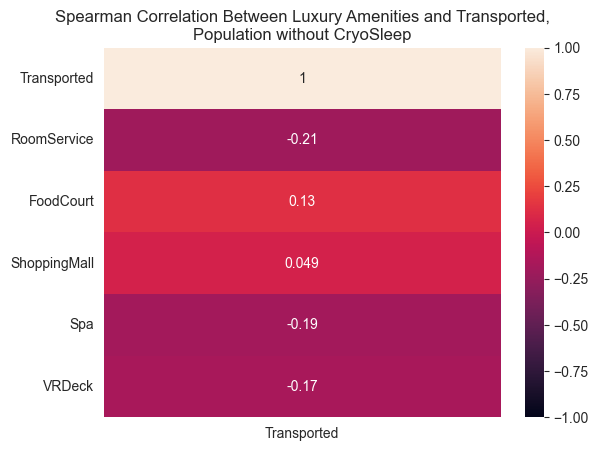

In [24]:
columns = ['Transported', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 
           'VRDeck']
df = spaceship_eda[columns][spaceship_eda.CryoSleep==False]

corr = df.corr('spearman')[['Transported']]
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.title('Spearman Correlation Between Luxury Amenities and '
          'Transported,\nPopulation without CryoSleep')
plt.show()

In [25]:
HTML('''
<div class="alert alert-block alert-info">
    <b>Correlation between features Insights:</b><br>
    After calculating correlations between the same type of data - 
    numerical, bianry, ordinal, multicategorical. Most correlation 
    coefficients are weak, which should not cause issues in ML. The 
    following several features were exceptions showing moderate correlation 
    coefficients: <br>
    1. FoodCourt and VRDeck or Spa <br>
    2. InGroup, GroupSize, and Deck <br>
    3. HomePlanet, Destination, Group<br><br>
    
    <b>Correlation between features and target Insights:</b><br>
    1. 'Age', 'VIP', 'Deck', 'Num', and 'Side' have extremely low values.<br>
    2. 'CryoSleep' has the best correlation. <br>
    3. All multicategorical features and luxury amenities are low to 
    moderately correlated. Note that these feature also showed correlation 
    between themselves.<br><br>
    
    <b>Correlation between CryoSleep and other features Insights:</b><br>
    1. Negligible correlations with multicatgory features. <br>
    2. Moderate to strong correlations with all luxury amenity features. But
     when considering only population who did not use CryoSleep, the 
     correlations dropped to weak.
</div>
''')

## 3.2. Statistical Inference
Objective: <br>
1. Check statistical significance between multicategorical features and 
target variable.
2. Check statistical significance between 'CryoSleep' and target variable.
3. Check statistical significance between luxury amenities and target variable.

Chi-Square Test

**Population:** all passengers with known values. <br>
**Null Hypothesis:** feature and target are independent. All groups are 
equally likely to be transported.<br>
**Alternative Hypothesis:** feature and target are dependent. At least one of 
the groups are less or more likely to be transported.

In [26]:
contingency_table_homeplanet = pd.crosstab(spaceship_train['HomePlanet'], 
                                spaceship_train['Transported'])
contingency_table_destination = pd.crosstab(spaceship_train['Destination'], 
                                        spaceship_train['Transported'])
contingency_table_group = pd.crosstab(spaceship_train['Group'], 
                                  spaceship_train['Transported'])
contingency_table_cryosleep = pd.crosstab(spaceship_train['CryoSleep'], 
                                          spaceship_train['Transported'])

In [27]:
contingency_table_homeplanet

Transported,False,True
HomePlanet,,
Earth,2651,1951
Europa,727,1404
Mars,839,920


In [28]:
contingency_table_destination

Transported,False,True
Destination,,
55 Cancri e,702,1098
PSO J318.5-22,395,401
TRAPPIST-1e,3128,2787


In [29]:
contingency_table_group

Transported,False,True
Group,,
0001,1,0
0002,0,1
0003,2,0
0004,0,1
0005,0,1
...,...,...
9275,1,2
9276,1,0
9278,1,0


In [30]:
contingency_table_cryosleep

Transported,False,True
CryoSleep,,
False,3650,1789
True,554,2483


In [31]:
chi_square_results = {col: chi_square_test(spaceship_train, col, target_name) 
                      for col in multicat_columns}
chi_square_results['CryoSleep'] = chi_square_test(
    spaceship_train, 'CryoSleep', target_name)
chi_square_df = pd.DataFrame(list(chi_square_results.items()), 
                             columns=['Feature', 'Chi-square p-value'])
chi_square_df

,Feature,Chi-square p-value
0,HomePlanet,2.809060e-71
1,Destination,7.892901e-24
2,Group,6.870372e-03
3,CryoSleep,0.000000e+00


All our p-values are <0.05, and very close to 0. This rejects the null 
hypothesis it tells us these features contain relevant information for our 
predictive model.<br>
1. Most who travelled from Earth were less likely to be transported, and 
from Europa were more likely.
2. Most whose destination were 55 Cancri e were more likely to be transported.
3. Most who were in CryoSleep were more likely to be transported.
4. Group had the highest p value of all, while still rejecting the null 
hypothesis. However, this feature contains many unique values and might not 
be actually that relevant for the model, just like PassengerId.

Mann-Whitney U test

**Population:** all passengers with known values, and were not in CryoSleep. 
<br>
**Null Hypothesis:** The distributions of the two groups (Transported = 0 and Transported = 1) are the same.<br>
**Alternative Hypothesis:** The distributions of the two groups are different.

In [32]:
columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df = spaceship_eda[spaceship_eda.CryoSleep==False]
stat_results = []
for col in columns:
    # Split data into two groups based on target variable
    group0 = df[df[target_name] == 0][col].dropna()
    group1 = df[df[target_name] == 1][col].dropna()
    
    # Perform Mann-Whitney U test
    mw_stat, mw_pval = mannwhitneyu(group0, group1)
    
    # Collect results
    stat_results.append({
        'Feature': col,
        'Mann-Whitney p-value': mw_pval
    })

# Convert results to DataFrame for easy viewing
stat_results_df = pd.DataFrame(stat_results)
stat_results_df

,Feature,Mann-Whitney p-value
0,RoomService,1.929674e-51
1,FoodCourt,6.314324e-21
2,ShoppingMall,3.856329e-04
3,Spa,7.494035e-46
4,VRDeck,1.631125e-35


Despite the correlation coefficients for luxury amenities had reduced 
significantly after removing passengers in CryoSleep, the statistical tests 
still show there are significant differences between passengers with 
different amenities spending habits.

## 3.3. Distribution

Drop columns PassengerId, Cabin, Group, and Num as they have a large amount of 
unqiue values, not suitable for visualization.

In [33]:
categorical_columns_selector = selector(dtype_exclude='number')
numerical_columns_selector = selector(dtype_include='number')

categorical_columns = categorical_columns_selector(data)
categorical_columns.remove('PassengerId')
categorical_columns.remove('Cabin')
categorical_columns.remove('Group')
categorical_columns.remove('Num')
numerical_columns = numerical_columns_selector(data)

**Numerical Features**

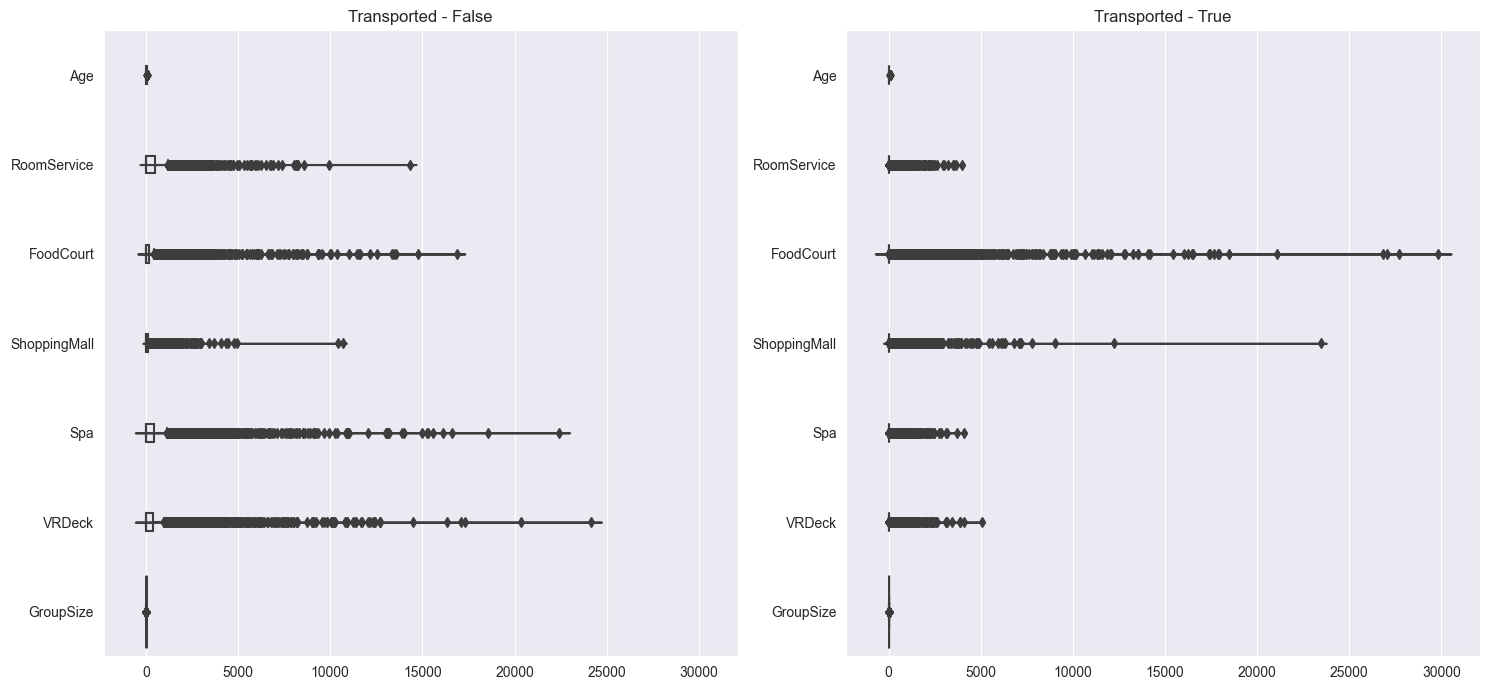

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), sharex=True)

violin_boxplot(data=spaceship_train[spaceship_train.Transported == True], 
               columns=numerical_columns, title='Transported - True', 
               ax=axes[1])
violin_boxplot(data=spaceship_train[spaceship_train.Transported == False], 
               columns=numerical_columns, title='Transported - False', 
               ax=axes[0])

plt.tight_layout()
plt.show()

Taking a closer look at the plots.

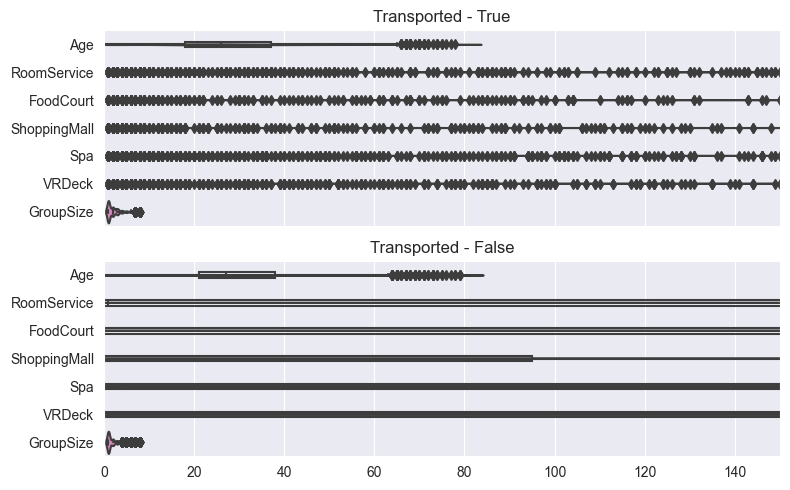

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), sharex=True)

violin_boxplot(data=spaceship_train[spaceship_train.Transported == True], 
               columns=numerical_columns, title='Transported - True', 
               ax=axes[0])
violin_boxplot(data=spaceship_train[spaceship_train.Transported == False], 
               columns=numerical_columns, title='Transported - False', 
               ax=axes[1])

axes[1].set_xlim(0, 150)
axes[0].set_xlim(0, 150)
plt.tight_layout()
plt.show()

In [36]:
spaceship_train[spaceship_train.Transported==True].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize
count,4288.000000,4295.000000,4279.000000,4264.000000,4287.000000,4280.000000,4378.000000
mean,27.748834,63.098021,532.691984,179.829972,61.675531,69.148131,2.166514
std,15.151705,274.812497,1931.306995,722.026714,262.682871,291.658171,1.616655
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,78.000000,3992.000000,29813.000000,23492.000000,4103.000000,5063.000000,8.000000


In [37]:
spaceship_train[spaceship_train.Transported==False].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize
count,4226.000000,4217.000000,4231.000000,4221.000000,4223.000000,4225.000000,4315.000000
mean,29.922858,389.266066,382.615930,167.566217,564.382666,543.629822,1.902665
std,13.699262,875.638123,1200.115601,456.528126,1551.356047,1563.088368,1.564494
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,27.000000,1.000000,0.000000,0.000000,4.000000,1.000000,1.000000
75%,38.000000,473.000000,179.000000,95.000000,453.500000,388.000000,2.000000
max,79.000000,14327.000000,16856.000000,10705.000000,22408.000000,24133.000000,8.000000


Notice all luxury amenities spending features display median 
values close to 0. When taken into account the whole IQR, people who were NOT 
 transported, had higher amenities spending, confirming the findings from 
 correlations.

**Categorical Features - without PassengerID, Name, Cabin**

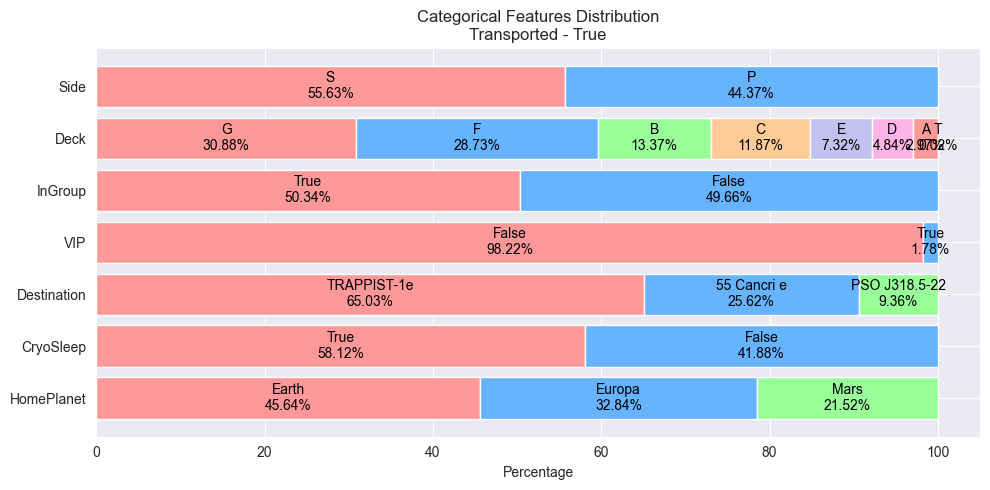

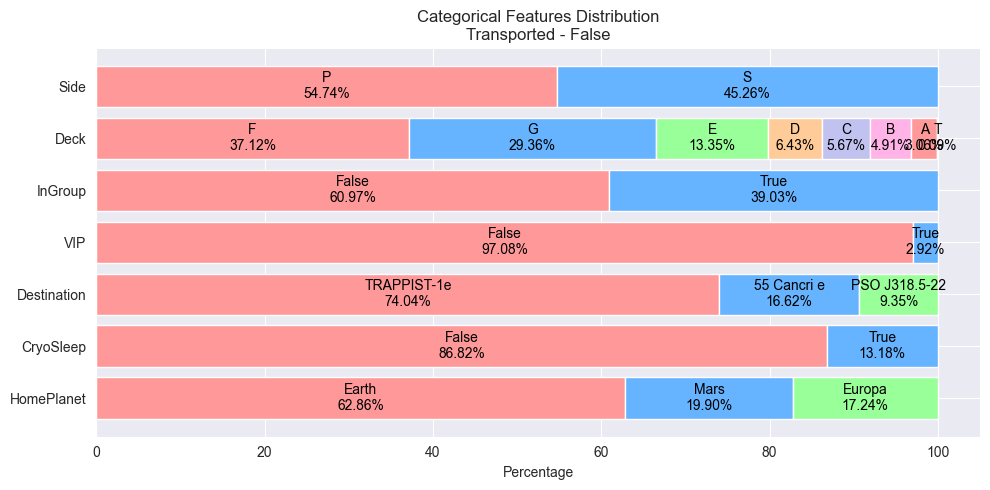

In [38]:
stacked_horizontal_feature_distribution(
    data=spaceship_train[spaceship_train.Transported == True], 
    columns=categorical_columns, 
    title='Categorical Features Distribution\nTransported - True') 

stacked_horizontal_feature_distribution(
    data=spaceship_train[spaceship_train.Transported == False], 
    columns=categorical_columns,
    title='Categorical Features Distribution\nTransported - False')

The distributions in general are coherent with what was observed at Data 
Cleaning and correlations.<br> 
There are some differences between the target labels, mainly at the 
numerical features, 'HomePlanet', 'Destination', and in the feature 
'CyroSleep'. <br>

# 4. Data Preprocessing

Separate data and target

In [39]:
spaceship_ml = spaceship_train.copy()
spaceship_ml = spaceship_ml.drop(['PassengerId', 'Cabin', 'Group', 'Num'], 
                                 axis=1)

X, y = (spaceship_ml.drop(columns=[target_name]).copy().reset_index(drop=True), 
            spaceship_ml[target_name].reset_index(drop=True))

**Define columns**<br>
Remove columns that do not contain relevant information for ML

In [40]:
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 
                     'Spa', 'VRDeck']
ordinal_yesno_columns = ['CryoSleep', 'VIP', 'InGroup', 'GroupSize', 'Side']
multicat_columns = ['HomePlanet', 'Destination', 'Deck']

for col in ordinal_yesno_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

**Define preprocessors for each data type**

In [41]:
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

multicat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False))
])

**Bundle preprocessors for all data**

In [42]:
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('ord', ordinal_pipeline, ordinal_yesno_columns),
        ('cat', multicat_pipeline, multicat_columns),
    ]
)

In [43]:
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_1)
])

# 5. Feature Selection
Objective:<br>
1. Baseline model - no feature selection
2. Feature selection by mutual information and PCA

## 5.1. All features included

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


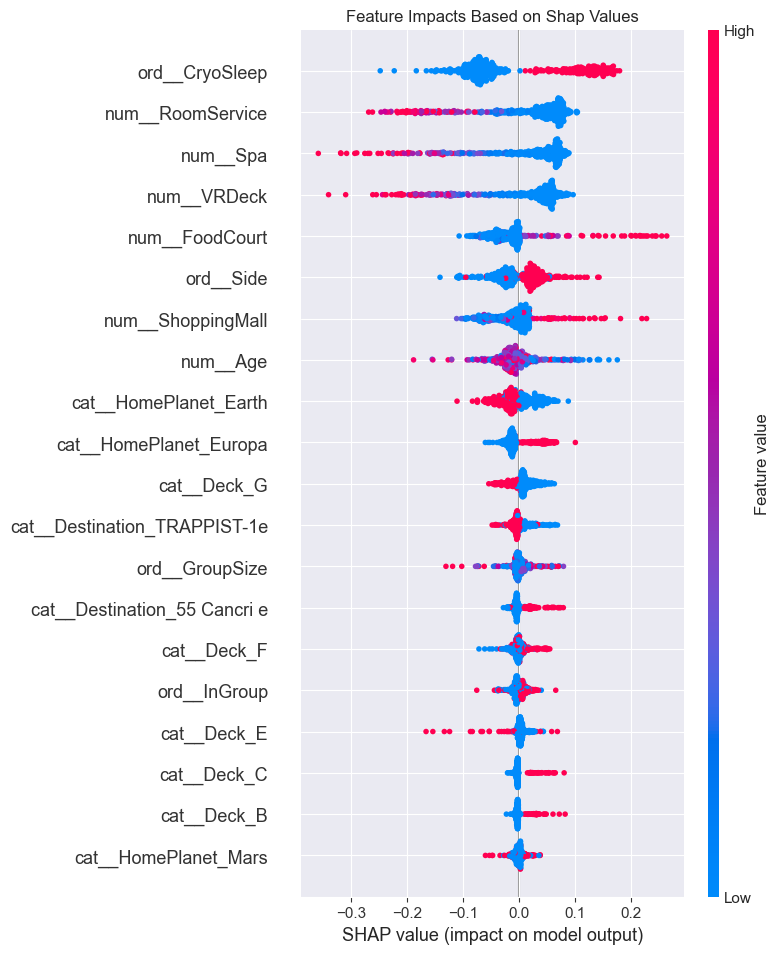

In [44]:
X_train_tf, y_train, X_eval_tf, y_eval = (prep_train_eval(preprocessor_1, X,
                                                          y))

model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train_tf, y_train)

shap.initjs()
observations = X_eval_tf.sample(500, random_state=0)
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(observations)
shap.summary_plot(shap_vals[1], observations, show=False)

plt.title("Feature Impacts Based on Shap Values")
plt.show()

In [45]:
y_pred = model.predict(X_eval_tf)
y_pred_proba = model.predict_proba(X_eval_tf)[:, 1]

evaluation_metrics = {
    'accuracy': accuracy_score(y_eval, y_pred),
    'roc_auc': roc_auc_score(y_eval, y_pred_proba),
    'precision': precision_score(y_eval, y_pred, zero_division=0),
    'recall': recall_score(y_eval, y_pred, zero_division=0),
    'f1': f1_score(y_eval, y_pred, zero_division=0)
}

evaluation_df = pd.DataFrame(evaluation_metrics, index=['Evaluation'])
evaluation_df

,accuracy,roc_auc,precision,recall,f1
Evaluation,0.788959,0.866151,0.805522,0.765982,0.785255


## 5.2. Mutual Information

In [46]:
mi_scores = mutual_info_classif(X_train_tf, y_train, 
                                discrete_features='auto', random_state=0)
mi_df = pd.DataFrame({'Feature': X_train_tf.columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

mi_df

,Feature,Mutual Information
6,ord__CryoSleep,0.119373
1,num__RoomService,0.069291
5,num__VRDeck,0.067586
4,num__Spa,0.061921
3,num__ShoppingMall,0.056176
2,num__FoodCourt,0.036489
18,cat__Deck_B,0.023453
12,cat__HomePlanet_Europa,0.018490
10,ord__Side,0.017247
0,num__Age,0.015427


Unsurprisingly, features when ordered by mutual information, CryoSleep is 
the first. Followed by all the luxury amenities spending.<br> 
The features with top 10 importance were the following:<br>
1. ord__CryoSleep
2. num__RoomService
3. num__VRDeck
4. num__Spa
5. num__ShoppingMall
6. num__FoodCourt
7. cat__Deck_B
8. cat__HomePlanet_Europa
9. ord__Side
10. num__Age

In [47]:
selected_features_threshold = (
    mi_df[mi_df['Mutual Information'] > 0.01]['Feature'].tolist())
print("Selected Features (Threshold > 0.01):", selected_features_threshold)

Selected Features (Threshold > 0.01): ['ord__CryoSleep', 'num__RoomService', 'num__VRDeck', 'num__Spa', 'num__ShoppingMall', 'num__FoodCourt', 'cat__Deck_B', 'cat__HomePlanet_Europa', 'ord__Side', 'num__Age', 'cat__Deck_E', 'cat__Deck_C', 'cat__Destination_TRAPPIST-1e', 'cat__Destination_55 Cancri e']


In [48]:
X_eval_tf_mi = X_eval_tf.copy()
X_eval_tf_mi = X_eval_tf_mi[selected_features_threshold]

X_train_tf_mi = X_train_tf.copy()
X_train_tf_mi = X_train_tf_mi[selected_features_threshold]

model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train_tf_mi, y_train)

RandomForestClassifier(random_state=0)

In [49]:
y_pred = model.predict(X_eval_tf_mi)
y_pred_proba = model.predict_proba(X_eval_tf_mi)[:, 1]

evaluation_metrics = {
    'accuracy': accuracy_score(y_eval, y_pred),
    'roc_auc': roc_auc_score(y_eval, y_pred_proba),
    'precision': precision_score(y_eval, y_pred, zero_division=0),
    'recall': recall_score(y_eval, y_pred, zero_division=0),
    'f1': f1_score(y_eval, y_pred, zero_division=0)
}

evaluation_df = pd.DataFrame(evaluation_metrics, index=['Evaluation'])
evaluation_df

,accuracy,roc_auc,precision,recall,f1
Evaluation,0.779183,0.851043,0.778281,0.785388,0.781818


## 5.3. PCA

By setting n_components=0.95, PCA keeps enough components to explain 95% of 
the variance.

In [50]:
n_components = 0.95
pca = PCA(n_components=n_components, random_state=0)

X_train_pca = pca.fit_transform(X_train_tf)
X_eval_pca = pca.transform(X_eval_tf)

X_pca_df = pd.DataFrame(X_train_pca,
                        columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,-0.904309,8.560772,-0.509145,0.886538,0.417594,-9.055135,-5.833308,0.009903,0.677158,0.639849,0.038266,1.042029,-0.340135,-0.291747
1,-1.039037,-0.496512,-0.401834,0.139261,0.514866,-0.685028,-0.153660,0.320423,-0.735418,-0.049141,-0.603330,-0.154438,0.475086,-0.043769
2,0.730316,0.177263,2.271526,-1.742331,-0.331597,0.339630,-0.114088,-0.055526,-0.633507,0.392524,0.228747,0.227315,-0.127655,-0.020644
3,-1.093971,0.162639,0.253764,0.615008,0.446156,-1.316776,-0.512877,0.373925,-0.608408,0.581304,0.206423,-0.019664,0.405526,-0.072071
4,0.260861,-0.156416,-0.520557,-0.055845,-0.235206,0.051846,0.114078,-1.428985,0.897908,0.457204,0.118434,-0.354810,0.218219,-0.032246


In [51]:
variance_explained = pca.explained_variance_ratio_
total_variance_explained = variance_explained.sum()

print("Variance Explained by Each Component:", variance_explained)
print("Total Variance Explained:", total_variance_explained)

Variance Explained by Each Component: [0.24314318 0.14323005 0.09958606 0.08537016 0.07650356 0.074441
 0.06794913 0.03768099 0.03451489 0.02684515 0.02514591 0.01762882
 0.01372753 0.01050218]
Total Variance Explained: 0.9562686143673299


In [52]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train_pca, y_train)

y_pred = model.predict(X_eval_pca)
y_pred_proba = model.predict_proba(X_eval_pca)[:, 1]

evaluation_metrics = {
    'accuracy': accuracy_score(y_eval, y_pred),
    'roc_auc': roc_auc_score(y_eval, y_pred_proba),
    'precision': precision_score(y_eval, y_pred, zero_division=0),
    'recall': recall_score(y_eval, y_pred, zero_division=0),
    'f1': f1_score(y_eval, y_pred, zero_division=0)
}

evaluation_df = pd.DataFrame(evaluation_metrics, index=['Evaluation'])
evaluation_df

,accuracy,roc_auc,precision,recall,f1
Evaluation,0.773433,0.85354,0.783529,0.760274,0.771727


**Feature Selection Insights:**<br>
    Comparing feature selection using PCA, simple 
    Mutual Information, and whole dataset without feature selection. It is 
    clear the metric scores were similar between all. Therefor, PCA will not
     be used for now, as it would make our model harder to interpret without
      much benefits.

# 6. Models
Objective:<br>
1. Apply and hyperparameter tuning machine learning models
2. Assess and select the best model

## 6.1. Baseline Model

As our dataset is balanced, it is adequate to use stratified strategy. The 
dummy classifier will randomly predict a class label for each sample, while 
maintaining the same class distribution as in the training data.

In [53]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train_tf_mi, y_train)

y_dummy_pred = dummy_clf.predict(X_eval_tf_mi)
y_pred_proba = dummy_clf.predict_proba(X_eval_tf_mi)[:, 1]
evaluation_metrics = {
    'accuracy': accuracy_score(y_eval, y_pred),
    'roc_auc': roc_auc_score(y_eval, y_pred_proba),
    'precision': precision_score(y_eval, y_pred, zero_division=0),
    'recall': recall_score(y_eval, y_pred, zero_division=0),
    'f1': f1_score(y_eval, y_pred, zero_division=0)
}

evaluation_df = pd.DataFrame(evaluation_metrics, index=['Evaluation'])
evaluation_df

,accuracy,roc_auc,precision,recall,f1
Evaluation,0.773433,0.518641,0.783529,0.760274,0.771727


## 6.2. Basic Model
Objective: Fit, evaluate and pick the model to work on.

**Models**

1. Logistic Regression
2. Random forest classifier
2. XGBoost gradient boosted trees
3. LightGBM histogram gradient boosting

In [54]:
log_reg = LogisticRegression(random_state=0)
random_forest = RandomForestClassifier(random_state=0)
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=0)
clf_lgb = lgb.LGBMClassifier(objective='binary', random_state=0)

**Pipeline**

In [55]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
feature_selector = SelectKBest(mutual_info_classif,
                               k=len(selected_features_threshold))

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('feature_selection', feature_selector),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=0))
])

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('feature_selection', feature_selector),
    ('classifier', clf_xgb)
])

pipeline_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('feature_selection', feature_selector),
    ('classifier', clf_lgb)
])

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('feature_selection', feature_selector),
    ('classifier', log_reg)
])

**Cross Validation**

*Primary Metric: Accuracy*<br>
The dataset is balanced and our problem does not have a specific focus on 
types of errors, so accuracy will be a straightforward measure of the 
model’s success in classifying the correct destination. <br><br>
*Secondary Metric: ROC AUC and F1 Score*<br>
1. ROC AUC: This will show how well the model distinguishes between 
Transported or not.
2. F1 Score: Provides a balanced view of precision and recall, ensuring
that each class is handled reasonably well in terms of both capturing and 
not over-predicting each class.


In [56]:
models = {
    "Random Forest": pipeline_rf,
    "XGBoost": pipeline_xgb,
    "LightGBM": pipeline_lgb,
    "Logistic Regression": pipeline_lr
}

thresholds_range = np.linspace(0, 1, 101)
model_results = {model_name: [] for model_name in models.keys()} 

Perform cross-validation and collect mean scores for each threshold 

In [57]:
thresholds_range = np.linspace(0, 1, 101)
standard_fpr = np.linspace(0, 1, 100)

# Initialize dictionary for model results if not done previously
model_results = {}

for model_name, pipeline in models.items():
    print(f"Evaluating {model_name}")
    
    # Initialize lists for each fold
    fprs, tprs, accuracies, f1s = [], [], [], [] 
    
    # Cross-validation loop
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit model and get probabilities
        pipeline.fit(X_train, y_train)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1)
        
        # Interpolate TPR at standard FPR points
        interp_tpr = np.interp(standard_fpr, fpr, tpr)
        interp_tpr[0] = 0.0  # Ensuring the curve starts at (0,0)
        
        # Append the FPR and interpolated TPR for this fold
        fprs.append(standard_fpr)
        tprs.append(interp_tpr)
        
        # Calculate Accuracy and F1 Score at multiple thresholds
        fold_accuracy, fold_f1 = [], []
        for threshold in thresholds_range:
            y_pred = (y_proba >= threshold).astype(int)
            fold_accuracy.append(accuracy_score(y_test, y_pred))
            fold_f1.append(f1_score(y_test, y_pred, zero_division=0))
        
        accuracies.append(fold_accuracy)
        f1s.append(fold_f1)

    # Calculate mean TPR, FPR, Accuracy, and F1 across folds
    mean_tpr = np.mean(tprs, axis=0)
    mean_fpr = standard_fpr  # standard FPR range
    mean_accuracy = np.mean(accuracies, axis=0)
    mean_f1 = np.mean(f1s, axis=0)
    
    # Calculate AUC based on mean TPR and FPR
    auc_score = auc(mean_fpr, mean_tpr)
    
    # Store results
    model_results[model_name] = {
        "mean_fpr": mean_fpr,
        "mean_tpr": mean_tpr,
        "mean_accuracy": mean_accuracy,
        "mean_f1": mean_f1,
        "auc_score": auc_score
    }


Evaluating Random Forest
Evaluating XGBoost
Evaluating LightGBM
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3506, number of negative: 3448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train s

Plotting Accuracy vs Threshold and F1 score vs Threshold for each model

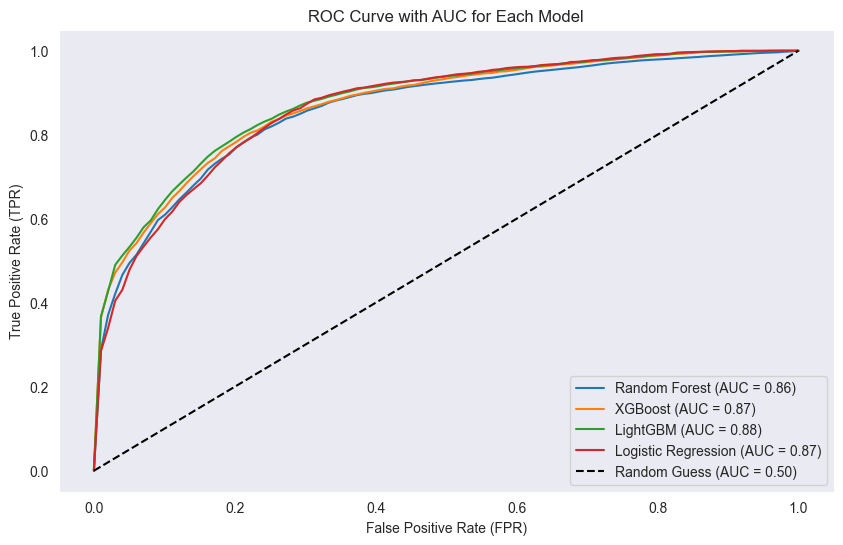

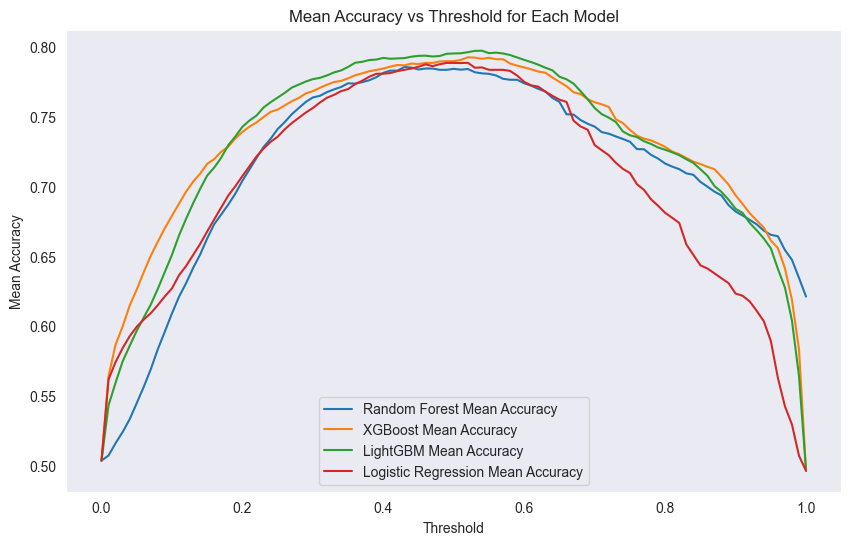

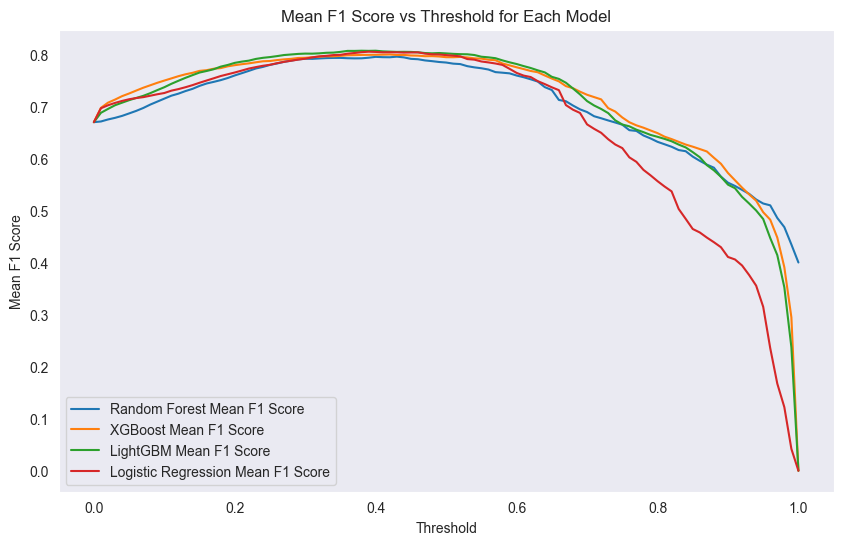

In [58]:
thresholds_range = np.linspace(0, 1, 101)

# Plotting AUC-ROC Curve for each model
plt.figure(figsize=(10, 6))
for model_name, metrics in model_results.items():
    mean_fpr = metrics["mean_fpr"]
    mean_tpr = metrics["mean_tpr"]
    
    auc_score = np.trapz(mean_tpr, mean_fpr)
    
    plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve with AUC for Each Model")
plt.legend()
plt.grid()
plt.show()


# Plotting Accuracy vs Threshold for each model
plt.figure(figsize=(10, 6))
for model_name, metrics in model_results.items():
    plt.plot(thresholds_range, metrics["mean_accuracy"], label=f'{model_name} Mean Accuracy')

plt.xlabel("Threshold")
plt.ylabel("Mean Accuracy")
plt.title("Mean Accuracy vs Threshold for Each Model")
plt.legend()
plt.grid()
plt.show()

# Plotting F1 Score vs Threshold for each model
plt.figure(figsize=(10, 6))
for model_name, metrics in model_results.items():
    plt.plot(thresholds_range, metrics["mean_f1"], label=f'{model_name} Mean F1 Score')

plt.xlabel("Threshold")
plt.ylabel("Mean F1 Score")
plt.title("Mean F1 Score vs Threshold for Each Model")
plt.legend()
plt.grid()
plt.show()

LightGBM has the best overall accuracy, AUC ROC, and F1 score for the 
validation set. <br>
The best threshold point, maximizing accuracy while balancing AUC and F1 
score, according to the graphs will be close to 0.5.

**Best Threshold for Chosen Model**

In [59]:
lightgbm_results = model_results["LightGBM"]

best_threshold_idx = np.argmax(lightgbm_results["mean_accuracy"])
best_threshold = thresholds_range[best_threshold_idx]
best_accuracy = lightgbm_results["mean_accuracy"][best_threshold_idx]
best_f1_at_best_threshold = lightgbm_results["mean_f1"][best_threshold_idx]

auc_roc = lightgbm_results["auc_score"]

print(f"Best Threshold for LightGBM (Max Accuracy): {best_threshold}")
print(f"Max Accuracy at Best Threshold: {best_accuracy}")
print(f"F1 Score at Best Threshold: {best_f1_at_best_threshold}")
print(f"AUC ROC for LightGBM: {auc_roc}")

Best Threshold for LightGBM (Max Accuracy): 0.54
Max Accuracy at Best Threshold: 0.797424415576853
F1 Score at Best Threshold: 0.7989108942660754
AUC ROC for LightGBM: 0.8777305290142087


Both F1 score and AUC ROC have improved significantly, compared to baseline 
model. However, Accuracy did not improve as much as expected.

## 6.3. Hyperparameter Tuning

**Run Optimization**

In [64]:
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Define the hyperparameter search space for LightGBM within the pipeline
    param_grid = {
        "classifier__n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "classifier__learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 0.1),
        "classifier__max_depth": trial.suggest_int("max_depth", 3, 12),
        "classifier__min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "classifier__subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "classifier__reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "classifier__reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
    }
    
    pipeline_lgb.set_params(**param_grid)
    
    cv_scores = cross_val_score(pipeline_lgb, X, y, cv=5, scoring="accuracy")
    
    return cv_scores.mean()


In [67]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers
                            .RandomSampler(seed=0))
study.optimize(objective, n_trials=10)

[I 2024-11-03 19:29:28,461] A new study created in memory with name: no-name-b3d8a727-a33a-4b65-9f44-530639009f68
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1378
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-03 19:29:40,660] Trial 0 finished with value: 0.7910983456095225 and parameters: {'n_estimators': 1143, 'learning_rate': 0.013981961408994055, 'max_depth': 9, 'min_child_samples': 57, 'subsample': 0.7118273996694524, 'reg_alpha': 0.006502000785097662, 'reg_lambda': 8.675307976899775e-05}. Best is trial 0 with value: 0.7910983456095225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1295
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-03 19:29:53,199] Trial 1 finished with value: 0.7813228771214228 and parameters: {'n_estimators': 1795, 'learning_rate': 0.07780155576901421, 'max_depth': 6, 'min_child_samples': 81, 'subsample': 0.7644474598764522, 'reg_alpha': 0.001295391520396607, 'reg_lambda': 2.13978305808933}. Best is trial 0 with value: 0.7910983456095225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-03 19:29:55,430] Trial 2 finished with value: 0.7406009564641399 and parameters: {'n_estimators': 235, 'learning_rate': 0.00018255254802399022, 'max_depth': 3, 'min_child_samples': 84, 'subsample': 0.8890783754749252, 'reg_alpha': 0.6762532016190338, 'reg_lambda': 6.42044426233932}. Best is trial 0 with value: 0.7910983456095225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1378
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-03 19:30:15,478] Trial 3 finished with value: 0.7981156584442337 and parameters: {'n_estimators': 1619, 'learning_rate': 0.0024234724484675954, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.819960510663762, 'reg_alpha': 1.9506510537765813e-07, 'reg_lambda': 3.177022228527139}. Best is trial 3 with value: 0.7981156584442337.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-03 19:30:24,449] Trial 4 finished with value: 0.7875330782144679 and parameters: {'n_estimators': 1092, 'learning_rate': 0.0017538232373118048, 'max_depth': 5, 'min_child_samples': 79, 'subsample': 0.7280751661082743, 'reg_alpha': 0.001305886823451577, 'reg_lambda': 1.4760742495197955e-08}. Best is trial 3 with value: 0.7981156584442337.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-03 19:30:36,816] Trial 5 finished with value: 0.7938589496628818 and parameters: {'n_estimators': 1274, 'learning_rate': 0.006859416411328701, 'max_depth': 9, 'min_child_samples': 95, 'subsample': 0.8409101495517417, 'reg_alpha': 1.7201689540343315e-05, 'reg_lambda': 8.5760555256054e-05}. Best is trial 3 with value: 0.7981156584442337.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:

[I 2024-11-03 19:30:54,190] Trial 6 finished with value: 0.7768342320725838 and parameters: {'n_estimators': 1426, 'learning_rate': 0.0001515920461138471, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.6051912805369204, 'reg_alpha': 1.4465607560792659e-07, 'reg_lambda': 6.900096401402642e-06}. Best is trial 3 with value: 0.7981156584442337.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-03 19:31:02,550] Trial 7 finished with value: 0.7944353824235322 and parameters: {'n_estimators': 791, 'learning_rate': 0.005135589606500232, 'max_depth': 7, 'min_child_samples': 99, 'subsample': 0.551022405374014, 'reg_alpha': 7.583868689982382e-07, 'reg_lambda': 2.829994952731329e-07}. Best is trial 3 with value: 0.7981156584442337.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1378
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1369
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:

[I 2024-11-03 19:31:18,513] Trial 8 finished with value: 0.7877634925035949 and parameters: {'n_estimators': 1341, 'learning_rate': 0.000575274081411669, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.5794847918227599, 'reg_alpha': 9.848640172873773e-08, 'reg_lambda': 0.008071724032088088}. Best is trial 3 with value: 0.7981156584442337.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_32461/55420894.py

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-03 19:31:22,816] Trial 9 finished with value: 0.7755690710174955 and parameters: {'n_estimators': 362, 'learning_rate': 0.0003888186473153669, 'max_depth': 6, 'min_child_samples': 83, 'subsample': 0.5485506378965306, 'reg_alpha': 0.34793984646334997, 'reg_lambda': 7.326316408987164e-08}. Best is trial 3 with value: 0.7981156584442337.


**Visualization**

In [68]:
optuna.visualization.plot_optimization_history(study)

Accuracy was optimized on the 3rd trial, without much or any improvement for
 the following trials.

In [71]:
optuna.visualization.plot_slice(study, params=[
    'n_estimators', 
    'learning_rate', 
    'max_depth', 
    'min_child_samples', 
    'subsample', 
    'reg_alpha', 
    'reg_lambda'
])

min_child_samples, n_estimators, and reg_lambda didn't show much influence 
to our accuracy.

## 6.4. Final Model

Now fitting the whole train data for final evaluation

In [72]:
best_params = study.best_params
print("Best Hyperparameters:", best_params)

pipeline_lgb.set_params(**{f"classifier__{k}": v for k, v in best_params.items()})
pipeline_lgb.fit(X, y)

Best Hyperparameters: {'n_estimators': 1619, 'learning_rate': 0.0024234724484675954, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.819960510663762, 'reg_alpha': 1.9506510537765813e-07, 'reg_lambda': 3.177022228527139}
[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1378
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['CryoSleep', 'VIP',
                                                   'InGroup', 'GroupSize',
                                                   'Side...
                                                   'Deck'])])),
                ('feature_selection',
                 SelectKBest(k=14,
                             score_func=<function mutual_info_classif at 0x14f167ee0>)),
                ('classifier',
                 LGBMClassifier(learning_rate=0.0024234724484675954,
                                max_depth=10, min_child_samples=16,
                                n_estimators=1619, objective='binary',
                                random_state=0,
                                reg_alpha=1.9506510537765813e-07,
                                reg_lambda=3.177022228527139,
                                subsample=0.819960510663762))])

In [ ]:
y_proba_new = pipeline_lgb.predict_proba(X_new)[:, 1]

# Apply the best threshold to convert probabilities to class labels
y_pred_new = (y_proba_new >= best_threshold).astype(int)

# Improvements

1. Deeper analysis of missing values.
2. Boruta for more thorough feature selection
3. Try CatBoost as the data has quite some categorical features.
4. 